# Import lib and dataset

In [25]:
import pandas as pd
import json
import numpy as np 
import matplotlib.pyplot as plt
from transformers import set_seed 
import nlpaug.augmenter.word as naw 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report 
from skmultilearn.problem_transform import BinaryRelevance 
from sklearn.feature_extraction.text import CountVectorizer 
import torch 
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split 
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
pd.set_option('display.max_colwidth', 200)


## Load data to json file

In [ ]:

# set width for dataframe display
# dataset_url = "https://git.io/nlp-with-transformers"
# df_issues = pd.read_json(dataset_url, lines=True)
# print(f"DataFrame shape: {df_issues.shape}")

In [26]:
df_issues = pd.read_json("dataset.json", lines=True)

In [27]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/transformers/issues/11044
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting started and issues
user,"{'login': 'stas00', 'id': 10676103, 'node_id': 'MDQ6VXNlcjEwNjc2MTAz', 'avatar_url': 'https://avatars.githubusercontent.com/u/10676103?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1', 'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed', 'name': 'DeepSpeed', 'color': '4D34F7', 'default': False..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the release, so please ignore for now]**\r\n\r\nThe DeepSpeed ZeRO-3 has been integrated into HF `transformers`. \r\n\r\nWhile I tried to write tests for a ..."


## Process data

In [28]:
df_issues["labels"] = (df_issues["labels"]
        .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [29]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}") 
df_counts.head(10).to_frame().T

Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage,Core: Pipeline,Feature request
count,2284,649,106,98,64,52,50,46,42,41


In [30]:
label_map = {"Core: Tokenization": "tokenization",
 "New model": "new model",
 "Core: Modeling": "model training",
 "Usage": "usage",
 "Core: Pipeline": "pipeline",
 "TensorFlow": "tensorflow or tf",
 "PyTorch": "pytorch",
 "Examples": "examples",
 "Documentation": "documentation"}

In [31]:
def filter_lables(x): 
    return [label_map[label] for label in x if label in label_map] 
df_issues["labels"] = df_issues["labels"].apply(filter_lables) 
all_labels = list(label_map.values()) 

In [32]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
df_counts.head(10).to_frame().T

Number of labels: 9


labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


## save the unlabels data

In [33]:
df_issues["split"] = "unlabeled"
mark = df_issues["labels"].apply(lambda x: len(x) > 0)
df_issues.loc[mark, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [34]:
# print some examples
for colume in ['title', 'body', 'labels']:
    print(f"{colume}: {df_issues[colume].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [35]:
# concat the title and body 
df_issues['text'] = (df_issues
                     .apply(lambda x: f"{x['title']} +  {x['body']}", axis=1))

In [36]:
df_issues['text'].head()

0    Potential incorrect application of layer norm in BlenderbotSmallDecoder +  In BlenderbotSmallDecoder,  layer norm is applied only on the token embeddings, and not on the hidden_states, whereas in ...
1    Multi-GPU seq2seq example evaluation significantly slower than legacy example evaluation +  \r\n### Who can help\r\n@patil-suraj @sgugger \r\n\r\nModels:\r\nT5\r\n\r\n## Information\r\n\r\nI've be...
2    [DeepSpeed] ZeRO stage 3 integration: getting started and issues +  **[This is not yet alive, preparing for the release, so please ignore for now]**\r\n\r\nThe DeepSpeed ZeRO-3 has been integrated...
3    Can't load model to estimater +  I was trying to follow the Sagemaker instructions [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html) to load the model I just trained and te...
4    [LXMERT] Unclear what img_tensorize does with color spaces +  ## Environment info\r\n\r\n- `transformers` version: Not using transformers directly, I'm loading a model "unc-nl

In [37]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset=['text'])
print(f"Remove {(len_before - len(df_issues)) / len_before:.2%} duplicates.")


Remove 1.88% duplicates.


## Plot the dataset

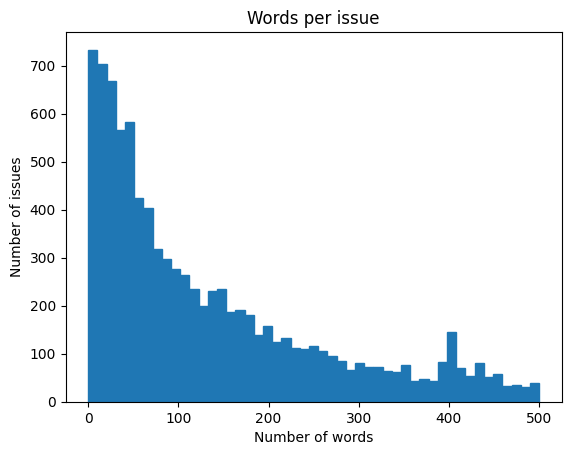

In [38]:
df_issues['text'].str.split().apply(len).hist(bins = np.linspace(0, 500, 50), grid=False, edgecolor='C0') 
plt.title("Words per issue") 
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

# Creating training set

In [39]:
#create balance split by using sk ml
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])  # example of target encoding

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

## split dataset

In [40]:
def balanced_split(df , test_size = 0.5): 
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"]) # transform labels to binary
    ind_train , _ , ind_test, _  = iterative_train_test_split(ind, labels, test_size=test_size) # split data
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]  # return train and test DataFrames

Example of balance split
![Alt text](image-1.png)

In [41]:
from sklearn.model_selection import train_test_split
df_clean = df_issues[["text" , "labels", "split"]].reset_index(drop=True).copy() 
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]].copy()
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]].copy()

np.random.seed(0)
 
df_train , df_tmp = balanced_split(df_sup, test_size=0.5) 
df_valid , df_test = balanced_split(df_tmp, test_size=0.5) 

## Create datasetDict

In [42]:
from datasets import Dataset, DatasetDict 
ds = DatasetDict({"train": Dataset.from_pandas(df_train.reset_index(drop=True)),
                  "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
                    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
                    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
                  })

## Creating Training slices

In [43]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))) , axis=1) 
print(f"Number of samples: {len(all_indices)}")
indices_pool = all_indices 
lables = mlb.transform(ds["train"]["labels"]) 
train_samples =  [8, 16, 32, 64, 128] 
train_slices , last_k = [], 0 
for i , k in enumerate(train_samples):
    # split off samples necessary to fill the gap to the next split size
    indices_pool, lables, new_slice, _ = iterative_train_test_split(indices_pool, lables, (k - last_k)/len(lables))
    last_k = k 
    if i == 0:
        train_slices.append(new_slice)
    else: train_slices.append(np.concatenate([train_slices[-1], new_slice]))
# add full dataset as last slice 
train_slices.append(all_indices) , train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(x) for x in train_slices]

Number of samples: 223


In [44]:
def prepare_labels(batch): 
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch
ds = ds.map(prepare_labels, batched=True) 

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [45]:
df_train.head()

,text,labels
26,Add new CANINE model + # 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncod...,[new model]
107,Please implement DUMA: Reading Comprehension with Transposition Thinking + # 🚀 Feature request\r\n\r\n<!-- A clear and concise description of the feature proposal.\r\n Please provide a link t...,[new model]
264,Can DeepSpeed ZeRO-3 be applied for training? + # 🌟 New model addition\r\n\r\nWe have applied DeepSpeed v0.3.10(ZeRO-2) on T5 training. \r\nI heard DeepSpeed ZeRO-3 library has been released 10 ...,[new model]
484,XLSR-53 + # 🚀 Feature request\r\n\r\nIs it possible to use XLSR-53 with transformers in the near future? \r\n,[new model]
566,[examples] should all examples support the predict stage? + This is part of the ongoing effort to sync the example scripts.\r\n\r\nIn https://github.com/huggingface/transformers/issues/10437#issu...,[examples]


In [46]:
from collections import defaultdict
macro_scores , micro_scores = defaultdict(list), defaultdict(list)

In [47]:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for run in micro_scores.keys():
        if run == current_model:
            print(run)
            ax0.plot(sample_sizes, micro_scores[run], label = run , linewidth=2)            
            ax1.plot(sample_sizes, macro_scores[run], label = run , linewidth=2)
        else:
            print(run)
            ax0.plot(sample_sizes, micro_scores[run], label=run,linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,linestyle="dashed")
    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()